In [4]:
import math
import random
import numpy as np

In [5]:
%load_ext cython

In [6]:
%%cython -a

import cython
import numpy as np
cimport numpy as np
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False) 

def _nn_search_cython(int q, np.ndarray[list, ndim = 1] d, int N):
    """
    find the nn set for ponit q
    """
    cdef np.ndarray P
    cdef int m, i
    
    m = d.shape[0]
    P = np.ndarray([q])
    for i in xrange(m):
        if q in d[i]:
            P = np.append(P, d[i])
                
    P = np.unique(P.astype(int))
    P = np.delete(P,np.where(P==q))
    P = np.delete(P,np.where(P<0))
    P = np.delete(P,np.where(P>N))
    return P

def nn_search_cython(q, d,N):
    return _nn_search_cython(q, d, N)

In [7]:
import numba
from numba import jit
from functools import reduce

In [8]:
from ipyparallel import Client
rc = Client()
dv = rc[:]

In [9]:
def get_input(x):
    temp = []
    for i,v in enumerate(x):
        temp.append([v,i])
    return temp

def chainHash(InputList, Leafs):
    res = {}
    for tup in InputList:
        if tup[0] not in res:
            temp = []
            temp.append(tup[1])
            res["%s" % tup[0]] = temp
        else:
            parent = list(map(lambda s: find_parentid(Leafs[s]), res["%s" % tup[0]]))
            if (find_parentid(Leafs[tup[1]]) not in parent) | (Leafs[tup[1]].parent is None):
                res["%s" % tup[0]].append(tup[1])
    return res

def find_parentid(Node):
    temp = None
    if Node.parent is not None:
        temp = find_parentid(Node.parent)
    else:
        temp = Node.id
    if temp>=0:
        return None
    else:
        return temp

def find_parentNode(Node):
    if Node.parent is not None:
        return find_parentNode(Node.parent)
    else:
        return Node

def euler_distance(point1, point2):
    """
    imput: point1, point2: list
    output: float
    """
    return np.linalg.norm(point1 - point2)


def flatten(xs, acc=[]):
    """Blah"""
    return list(reduce(lambda x,y: x+y,xs))

@dv.parallel(block = True)
def change_unary2(x):
    temp = ''
    for num in x:
        tem = int(11 - num)
        temp += ("1"*(11-tem)+ "0"*tem)
    return temp

In [10]:
class Nodes(object):
    def __init__(self,id):
        """
        :param parient
        :param children
        :param id
        """
        self.parent = None
        self.children = []
        self.id = id
    def add_leaf(self, leaf):
        if leaf not in self.children:
            self.children.append(leaf)
    def set_parent(self, node):
        if self.parent is not None:
            pass
        else:
            self.parent = node
    def show_childrenid(self):
        temp = []
        for child in self.children:
            temp.append(child.id)
        return temp
    def display(self,depth):
        print ('-'*depth + "  " +str(self.id))
        for child in self.children:
            child.display(depth+2)
    
class Leafs(Nodes):
    def __init__(self,id, vec):
        """
        :param vec
        :param parient
        :param children
        :param id
        """
        self.vec = vec
        self.parent = None
        self.children = []
        self.id = id
    def add_leaf(self,leaf):
        raise Exception("Leaf nodes can't insert catalog")
    def set_parent(self, node):
        if self.parent is not None:
            raise Exception("It has a parent already")
        else:
            self.parent = node

In [11]:
class LSH(object):
    def __init__(self, k, l, C, d):
        """
        k: number of sampled bits
        l: number of hash functions
        C: a constant
        d: number of attributes

        """
        assert l > 0
        assert k > 0
        self.k = k
        self.l = l
        self.C = C
        self.d = d
        self.I = []
    def creat_I(self):
        """
        create l distinct hash functions
        """
        while (len(self.I) < self.l):
            temp = sorted(random.sample(range(self.C*self.d),self.k))
            if temp not in self.I:
                self.I.append(temp)
                
    @dv.parallel(block = True)
    def change_unary(self, x):
        """
        change the list into unary expression
        x: list[1*d]
        """
        temp = ''
        for num in x:
            tem = int(self.C - num)
            temp += ("1"*(self.C-tem)+ "0"*tem)
        return temp
    
    def get_h_value(self, v, fun_I):
        temp = np.array(list(v))
        return ''.join(temp[fun_I])
    def hash_table(self,data): 
        """
        each row shows one hash function
        """
        m,n = np.shape(data)
        h_table = []
        v_table = np.array(change_unary2.map(data))
        self.creat_I()
        for fun_I in self.I:
            temp = list(map(lambda s: self.get_h_value(s, fun_I), v_table))
            h_table.append(temp)
        return np.array(h_table)
    def get_buckets(self,Leafs,h_table):
        r = list(map(lambda s: chainHash(get_input(s), Leafs),h_table))
        return r

In [12]:
class Hierarchical(object):
    def __init__(self):
        self.labels = None
        self.Nodes = []
        self.point_num = 0
    def merge_nodes(self, node1, node2):
        newid = -len(self.Nodes)-1
        flag = 0
        if (node1.parent is not None) & (node2.parent is not None):
            if find_parentid(node1) == find_parentid(node2):
                flag = 1
            else:
                NewNode = Nodes(id = newid)
                NewNode.add_leaf(find_parentNode(node1))
                NewNode.add_leaf(find_parentNode(node2))
                find_parentNode(node1).set_parent(NewNode)
                find_parentNode(node2).set_parent(NewNode)
                self.Nodes.append(NewNode)
        if (node1.parent is not None) & (node2.parent is None):
            newid = find_parentid(node1)
            self.Nodes[np.abs(newid)-1].add_leaf(node2)
            node2.set_parent(self.Nodes[np.abs(newid)-1])
        if (node1.parent is None) & (node2.parent is not None):
            newid = find_parentid(node2)
            self.Nodes[np.abs(newid)-1].add_leaf(node1)
            node1.set_parent(self.Nodes[np.abs(newid)-1])
        if (node1.parent is None) & (node2.parent is None):
            NewNode = Nodes(id = newid)
            NewNode.add_leaf(node1)
            NewNode.add_leaf(node2)
            node1.set_parent(NewNode)
            node2.set_parent(NewNode)
            self.Nodes.append(NewNode)
        return flag
             
    def fit(self, x, R, A, C,l):
        """
        x:raw data, m*n
        R: minimun distance
        A: the ratio to increase R
        l: number of hash functions
        C: a constant
        """
        leafs = [Leafs(vec=v, id=i) for i,v in enumerate(x)]
        distances = {}
        self.point_num, future_num = np.shape(x)  
        self.labels = [ -1 ] * self.point_num
        currentNo = self.point_num
        i = 1
        while (currentNo > 1) & (R < 20):
            #k = int(future_num * C * np.sqrt(future_num)/(2 * R))+3
            k = 10
            ls = LSH(k,l ,C ,d = future_num)
            h_table = ls.hash_table(x)
            r = ls.get_buckets(leafs, h_table)
            w = np.array(flatten(list(map(lambda s: list(s.values()),r))))
            for p in range(self.point_num):
                P = nn_search_cython(p, w, self.point_num+1).astype(int)
                for q in P:
                    d_key = (p, q)
                    if d_key not in distances:
                        distances[d_key] = euler_distance(leafs[p].vec, leafs[q].vec)
                    d = distances[d_key]
                    if i <= 1:
                        if d <= R:
                            flag = self.merge_nodes(leafs[p], leafs[q])
                            if flag == 0:
                                currentNo -= 1
                    else:
                        if (d <= R) & (d > R/A):
                            flag = self.merge_nodes(leafs[p], leafs[q])
                            if flag == 0:
                                currentNo -= 1
            i += 1
            R = R*A
        for i in range(self.point_num):
            self.labels[i] = find_parentid(leafs[i])

    def display_depth(self, depth):
        self.Nodes[-1].display(depth)


### First Simulated Dataset

In [33]:
x0 = 3 + np.random.normal(loc=0, scale=1, size = (200,))
y0 = 15 + np.random.normal(loc=0, scale=1, size = (200,))

x1 = np.linspace(4, 8, num = 100) 
x1_coord = np.linspace(4, 8, num = 100) 
y1 = 8 + np.sqrt(4 - (x1_coord - 6)**2)
y1_coord = y1
y2_coord = 8 - np.sqrt(4 - (x1_coord - 6)**2)
x2 = np.r_[x1_coord, x1_coord].reshape(200,) + np.random.normal(loc=0, scale=0.2, size = (200,))
y2 = np.r_[y1_coord, y2_coord].reshape(200,) + np.random.normal(loc=0, scale=0.2, size = (200,))

x3 = 10 + np.random.normal(loc=0, scale=5, size = (200,))
y3 = 4 + np.random.normal(loc=0, scale=0.3, size = (200,))

x4 = 18 + np.random.normal(loc=0, scale=0.2, size = (200,))
y4 = 10 + np.random.normal(loc=0, scale=3, size = (200,))

x5 = 8 + np.random.normal(loc=0, scale=0.2, size = (200,))
y5 = 15 + np.random.normal(loc=0, scale=0.2, size = (200,))

x6 = 15 + np.random.normal(loc=0, scale=0.2, size = (200,))
y6 = 12 + np.random.normal(loc=0, scale=2.5, size = (200,))

x7 = 6 + np.random.normal(loc=0, scale=0.1, size = (200,))
y7 = 8 + np.random.normal(loc=0, scale=0.1, size = (200,))

xs = np.r_[x0, x1, x2, x3, x4, x5, x6, x7]
ys = np.r_[y0, y1, y2, y3, y4, y5, y6, y7]

In [34]:
data = []
for i,v in zip(xs,ys):
    data.append(np.array([i,v]))

In [35]:
import pandas as pd
data = pd.DataFrame(data)
data = (data - data.min())/(data.max() - data.min())
test2 = data.values
test2 = test2 * 10

In [36]:
%%time
lsh = Hierarchical()
lsh.fit(test2, R =0.8, A =1.5, C = 11, l = 30)

CPU times: user 22.1 s, sys: 436 ms, total: 22.5 s
Wall time: 22.8 s


In [37]:
lsh.display_depth(2)

--  -37
----  -27
------  -26
--------  900
--------  901
--------  902
--------  903
--------  904
--------  905
--------  906
--------  907
--------  908
--------  909
--------  910
--------  911
--------  912
--------  913
--------  914
--------  915
--------  916
--------  917
--------  918
--------  919
--------  920
--------  921
--------  922
--------  923
--------  924
--------  925
--------  926
--------  927
--------  928
--------  929
--------  930
--------  931
--------  932
--------  933
--------  934
--------  935
--------  936
--------  937
--------  938
--------  939
--------  940
--------  941
--------  942
--------  943
--------  944
--------  945
--------  946
--------  947
--------  948
--------  949
--------  950
--------  951
--------  952
--------  953
--------  954
--------  955
--------  956
--------  957
--------  958
--------  959
--------  960
--------  961
--------  962
--------  963
--------  964
--------  965
--------  966
--------  967
--------  968
----

------------------------  310
------------------------  311
------------------------  312
------------------------  313
------------------------  314
------------------------  315
------------------------  400
------------------------  401
------------------------  402
------------------------  403
------------------------  404
------------------------  405
------------------------  406
------------------------  407
------------------------  408
------------------------  409
------------------------  410
------------------------  411
------------------------  412
------------------------  413
------------------------  415
------------------------  1300
------------------------  1301
------------------------  1303
------------------------  1304
------------------------  1305
------------------------  1306
------------------------  1308
------------------------  1309
------------------------  1310
------------------------  1311
------------------------  1312
------------------------  131

--------------  1252
--------------  1253
--------------  1254
--------------  1257
--------------  1268
--------------  1274
--------------  1289
--------------  1292
--------------  1294
--------------  1296
--------------  1149
--------------  1150
--------------  1172
--------------  1185
--------------  1228
--------------  1262
--------------  1270
--------------  1109
--------------  1142
--------------  1193
--------------  1206
--------------  1213
--------------  1215
--------------  1223
--------------  1161
--------------  1226
--------------  1130
------------  1272
------------  1144
------------  1245
------------  1269
------------  1287
------------  1295
--------  -16
----------  617
----------  655
------  -17
--------  700
--------  780
------  806


In [89]:
lsh.Nodes[-7].children[1].id

-28

In [92]:
def find_children(q, temp = []):
    l = lsh.Nodes[q].children
    for num in l:
        if num.id>=0:
            temp.append(num.id)
        else:
            find_children((-num.id-1))
    return temp
c1 = find_children(26)

In [93]:
def find_children(q, temp = []):
    l = lsh.Nodes[q].children
    for num in l:
        if num.id>=0:
            temp.append(num.id)
        else:
            find_children((-num.id-1))
    return temp
c2 = find_children(16)

In [94]:
def find_children(q, temp = []):
    l = lsh.Nodes[q].children
    for num in l:
        if num.id>=0:
            temp.append(num.id)
        else:
            find_children((-num.id-1))
    return temp
c3 = find_children(15)

In [95]:
def find_children(q, temp = []):
    l = lsh.Nodes[q].children
    for num in l:
        if num.id>=0:
            temp.append(num.id)
        else:
            find_children((-num.id-1))
    return temp
c4 = find_children(12)

In [96]:
def find_children(q, temp = []):
    l = lsh.Nodes[q].children
    for num in l:
        if num.id>=0:
            temp.append(num.id)
        else:
            find_children((-num.id-1))
    return temp
c5 = find_children(24)

In [97]:
def find_children(q, temp = []):
    l = lsh.Nodes[q].children
    for num in l:
        if num.id>=0:
            temp.append(num.id)
        else:
            find_children((-num.id-1))
    return temp
c6 = find_children(28)

In [98]:
def find_children(q, temp = []):
    l = lsh.Nodes[q].children
    for num in l:
        if num.id>=0:
            temp.append(num.id)
        else:
            find_children((-num.id-1))
    return temp
c7 = find_children(30)

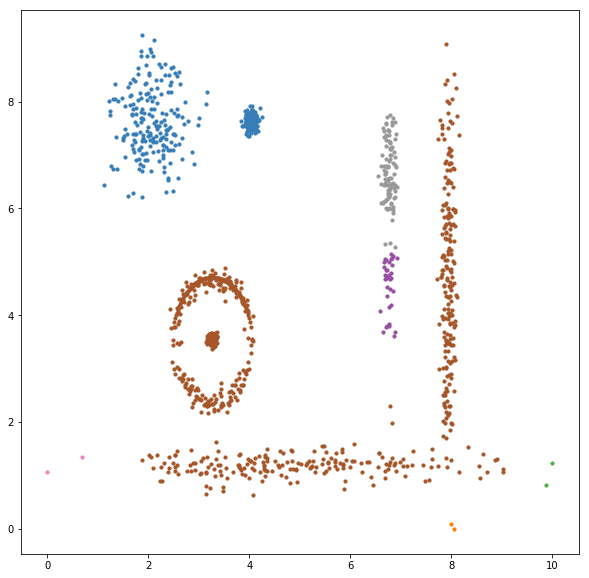

In [99]:
colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

plt.figure(figsize=(10,10))
plt.scatter(test2[c1,0], test2[c1,1], s=10, color = colors[0])
plt.scatter(test2[c2,0], test2[c2,1], s=10, color = colors[1])
plt.scatter(test2[c3,0], test2[c3,1], s=10, color = colors[2])
plt.scatter(test2[c4,0], test2[c4,1], s=10, color = colors[3])
plt.scatter(test2[c5,0], test2[c5,1], s=10, color = colors[4])
plt.scatter(test2[c6,0], test2[c6,1], s=10, color = colors[5])
plt.scatter(test2[c7,0], test2[c7,1], s=10, color = colors[6])
pass

### Second Simulated Dataset

In [15]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from functools import partial

np.random.seed(0)

n_samples = 1500

X, y = noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)

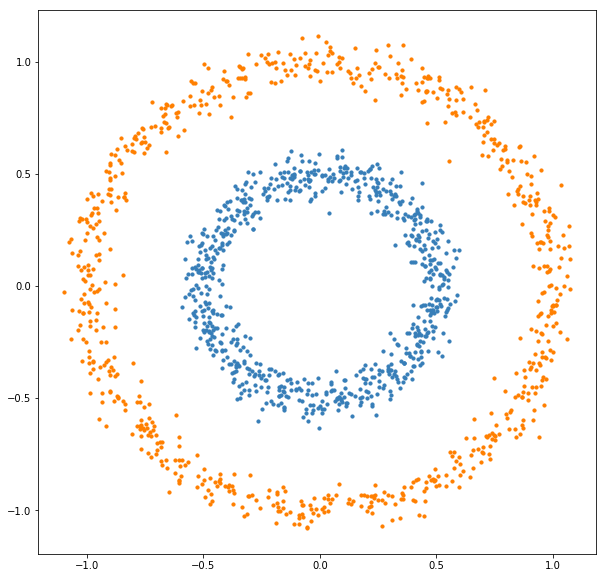

In [16]:
## Truth

colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

plt.figure(figsize=(10,10))
plt.scatter(X[y==0,0], X[y==0,1], s=10, color = colors[1])
plt.scatter(X[y==1,0], X[y==1,1], s=10, color = colors[0])
pass

In [18]:
import pandas as pd

In [19]:
d = pd.DataFrame(X)

In [20]:
d = (d+1) *5

In [21]:
X_trans = d.values

In [22]:
lsh = Hierarchical()
lsh.fit(X_trans, R = 1, A = 1.5, C = 11, l = 30)

In [23]:
lsh.display_depth(0)

  -43
--  -42
----  -41
------  -26
--------  -25
----------  40
----------  127
----------  128
----------  136
--------  -22
----------  24
----------  133
----------  141
----------  154
----------  191
----------  193
----------  242
----------  303
----------  323
----------  440
----------  558
----------  597
----------  613
----------  653
----------  717
----------  735
----------  740
----------  776
----------  862
----------  865
----------  868
----------  936
----------  1056
----------  1074
----------  1081
----------  1095
----------  1105
----------  1114
----------  1117
----------  1134
----------  1178
----------  1220
----------  1258
----------  1267
----------  1290
----------  1304
----------  1389
----------  1398
----------  1412
--------  144
--------  185
--------  234
--------  254
--------  345
--------  394
--------  400
--------  405
--------  409
--------  421
--------  462
--------  500
--------  548
--------  618
--------  674
--------  685
-------- 

----  1125
----  1182
----  1186
----  1422
----  1440
----  643
----  999
----  931
--  -29
----  -28
------  -27
--------  42
--------  84
------  -20
--------  -6
----------  4
----------  27
----------  52
----------  70
----------  85
----------  113
----------  114
----------  120
----------  135
----------  143
----------  153
----------  172
----------  179
----------  207
----------  214
----------  217
----------  244
----------  246
----------  253
----------  276
----------  311
----------  312
----------  328
----------  334
----------  340
----------  364
----------  382
----------  386
----------  448
----------  474
----------  478
----------  491
----------  503
----------  516
----------  554
----------  564
----------  567
----------  570
----------  594
----------  601
----------  608
----------  615
----------  634
----------  647
----------  663
----------  677
----------  684
----------  716
----------  756
----------  772
----------  797
----------  802
--------

------  849
------  1055
------  1152
------  1177
------  1221
------  1231
------  1260
------  1302
------  1499
------  287
------  318
------  639
------  681
------  1307
----  1469
----  1475
----  1495
----  1497
----  213
----  563
----  1286
----  1432
----  1000
----  78
----  290
----  335
----  338
----  347
----  425
----  671
----  745
----  971
----  1019
----  1044
----  1116
----  1249
----  1346
----  1448
----  1462
----  1334
----  247
----  137
----  1092
----  1145
----  1410
----  1478
----  156
----  1003


In [29]:
lsh.Nodes[-1].children[1].id

-29

In [25]:
def find_children(q, temp = []):
    l = lsh.Nodes[q].children
    for num in l:
        if num.id>=0:
            temp.append(num.id)
        else:
            find_children((-num.id-1))
    return temp
c1 = find_children(41)

In [30]:
def find_children(q, temp = []):
    l = lsh.Nodes[q].children
    for num in l:
        if num.id>=0:
            temp.append(num.id)
        else:
            find_children((-num.id-1))
    return temp
c2 = find_children(28)

In [31]:
x1 = X[c1]
x2 = X[c2]

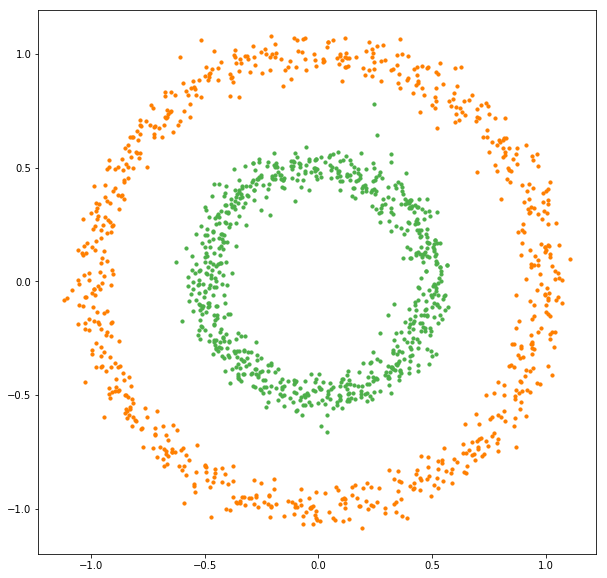

In [32]:
colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

plt.figure(figsize=(10,10))
plt.scatter(x1[:,0], x1[:,1], s=10, color = colors[1])
plt.scatter(x2[:,0], x2[:,1], s=10, color = colors[2])
pass